In [1]:
#pip install torchinfo

In [2]:
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

In [3]:
### Dowenload Mnist Data
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

In [4]:
# Save MNIST training and testing datasets as images
# Define paths
base_dir = './mnist_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
def save_mnist_images(dataset, save_dir):
    for idx,(image, label) in tqdm(enumerate(dataset)):
        label_dir = os.path.join(save_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
        image.save(os.path.join(label_dir, f'{idx}.png'))
# Save images
save_mnist_images(train_dataset, train_dir)
save_mnist_images(test_dataset, test_dir)

60000it [00:43, 1391.49it/s]
10000it [00:06, 1465.39it/s]


In [5]:
# Define transforms: Used to preprocess the images before feeding them into the model
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.ToTensor(),  # Converts the image to a tensor, normalizing pixel values to the range [0, 1]
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the image to range [-1, 1], making it easier for the model to learn
])

In [6]:
# Creating training and testing datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)  # Load training data with transformations
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)  # Load test data with transformations
### Train
print("Train:\n","*"*20)
print(f"Number of samples: {len(train_dataset)}")  
print(f"Class names: {train_dataset.classes}")  
print(f"Class-to-index mapping: {train_dataset.class_to_idx}") 
print(f"Image size (first sample): {train_dataset[0][0].size()}")  
print(f"Data directory: {train_dataset.root}") 
### Test
print("Test:\n","*"*20)
print(f"Number of samples: {len(test_dataset)}")  
print(f"Class names: {test_dataset.classes}")  
print(f"Class-to-index mapping: {test_dataset.class_to_idx}") 
print(f"Image size (first sample): {test_dataset[0][0].size()}")  
print(f"Data directory: {test_dataset.root}") 

Train:
 ********************
Number of samples: 60000
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Class-to-index mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Image size (first sample): torch.Size([1, 28, 28])
Data directory: ./mnist_data\train
Test:
 ********************
Number of samples: 10000
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Class-to-index mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Image size (first sample): torch.Size([1, 28, 28])
Data directory: ./mnist_data\test


In [7]:
# Create DataLoaders: DataLoaders are used to iterate over the dataset in batches during training/testing.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle training data for randomness
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No shuffle for test data, it’s typically not needed

In [42]:
# Function to visualize a batch of images
def show_batch(loader,predict_labels=[]):
    data_iter = iter(loader)  # Convert the loader to an iterator
    images, labels = next(data_iter)  # Get a batch of images and labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))  # Set up a grid of 2 rows and 5 columns to show images
    for i, ax in enumerate(axes.flat):  # Loop through each subplot (flattened 2D array)
        ax.imshow(images[i].permute(1, 2, 0),"gray")  # Convert (C, H, W) to (H, W, C) for RGB display4
        title = f"Label: {labels[i]}"
        if len(predict_labels):
            title = f"Label: {labels[i]}\nPredict: {predict_labels[i]}"
        ax.set_title(title)  # Set the title of the subplot as the label for each image
        ax.axis('off')  # Hide axis to focus on images
    plt.show()

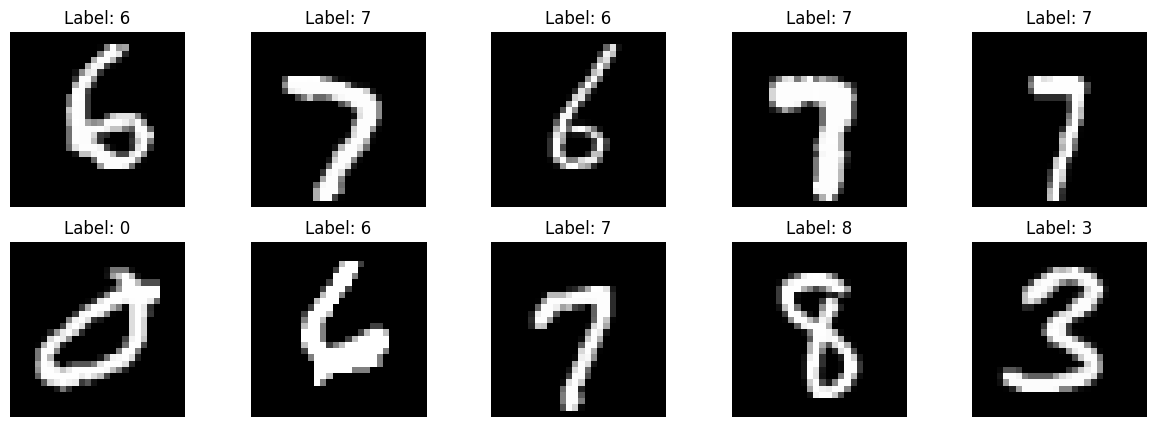

In [11]:
# Show a batch of images: This function will show a random batch of images from the training set.
show_batch(train_loader)  

In [12]:
### Create Custom Function to Calculate Mean & Std for Normilization
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for Images, labels in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(Images, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(Images**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.1307])
Standard deviation: tensor([0.3081])


In [13]:
# Define transforms: Used to preprocess the images before feeding them into the model
transform_norm = transforms.Compose([
    transforms.Grayscale(), 
    transforms.ToTensor(),  # Converts the image to a tensor, normalizing pixel values to the range [0, 1]
    transforms.Normalize(mean,std)  # Normalize the image to range [-1, 1], making it easier for the model to learn
])

In [14]:
# Creating training and testing datasets using ImageFolder
train_dataset_norm = datasets.ImageFolder(root=train_dir, transform=transform_norm)  # Load training data with transformations
test_dataset_norm = datasets.ImageFolder(root=test_dir, transform=transform_norm)  # Load test data with transformations
### Train
print("Train:\n","*"*20)
print(f"Number of samples: {len(train_dataset_norm)}")  
print(f"Class names: {train_dataset_norm.classes}")  
print(f"Class-to-index mapping: {train_dataset_norm.class_to_idx}") 
print(f"Image size (first sample): {train_dataset_norm[0][0].size()}")  
print(f"Data directory: {train_dataset_norm.root}") 
### Test
print("Test:\n","*"*20)
print(f"Number of samples: {len(test_dataset_norm)}")  
print(f"Class names: {test_dataset_norm.classes}")  
print(f"Class-to-index mapping: {test_dataset_norm.class_to_idx}") 
print(f"Image size (first sample): {test_dataset_norm[0][0].size()}")  
print(f"Data directory: {test_dataset_norm.root}") 

Train:
 ********************
Number of samples: 60000
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Class-to-index mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Image size (first sample): torch.Size([1, 28, 28])
Data directory: ./mnist_data\train
Test:
 ********************
Number of samples: 10000
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Class-to-index mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Image size (first sample): torch.Size([1, 28, 28])
Data directory: ./mnist_data\test


In [15]:
### use an 50/50 split. The random_split function will help us perform the split.
g = torch.Generator()
g.manual_seed(42)
test_dataset_norm, val_dataset_norm = random_split(test_dataset_norm, [0.5, 0.5], generator=g)

In [16]:
# Create DataLoaders: DataLoaders are used to iterate over the dataset in batches during training/testing.
train_loader_norm = DataLoader(train_dataset_norm, batch_size=64, shuffle=True)  # Shuffle training data for randomness
test_loader_norm = DataLoader(test_dataset_norm, batch_size=64, shuffle=False)  # No shuffle for test data, it’s typically not needed
val_loader_norm = DataLoader(val_dataset_norm, batch_size=64, shuffle=False)  # No shuffle for test data, it’s typically not needed

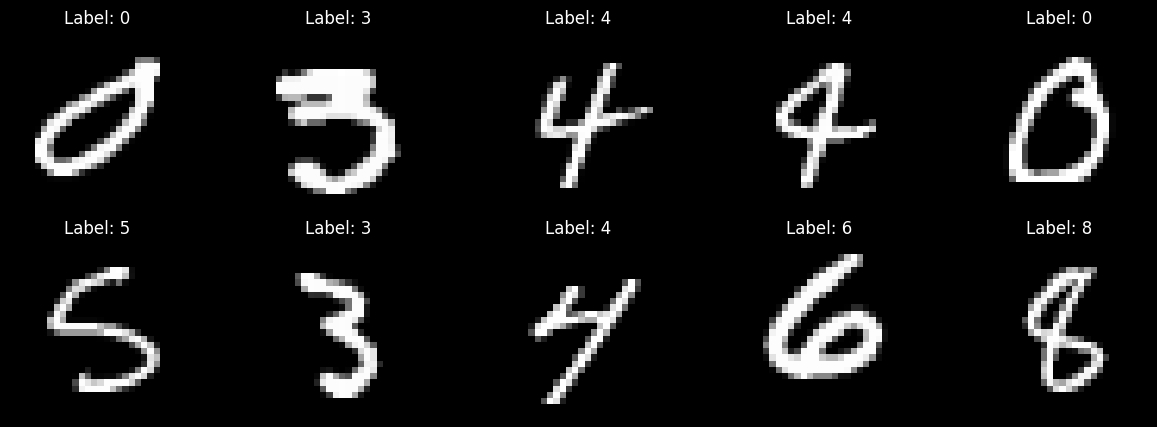

In [46]:
# Show a batch of images: This function will show a random batch of images from the training set norm.
show_batch(train_loader_norm)  

In [18]:
### Count each Class in Dataset
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = train_dataset_norm.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

train_class_distributions = class_counts(train_dataset_norm)
train_class_distributions

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:17<00:00, 3459.98it/s]


0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

In [19]:
test_class_distributions = class_counts(test_dataset_norm)
test_class_distributions

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 267.15it/s]


0    512
1    563
2    500
3    501
4    472
5    464
6    483
7    514
8    489
9    502
dtype: int64

In [20]:
val_class_distributions = class_counts(val_dataset_norm)
val_class_distributions

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 266.23it/s]


0    468
1    572
2    532
3    509
4    510
5    428
6    475
7    514
8    485
9    507
dtype: int64

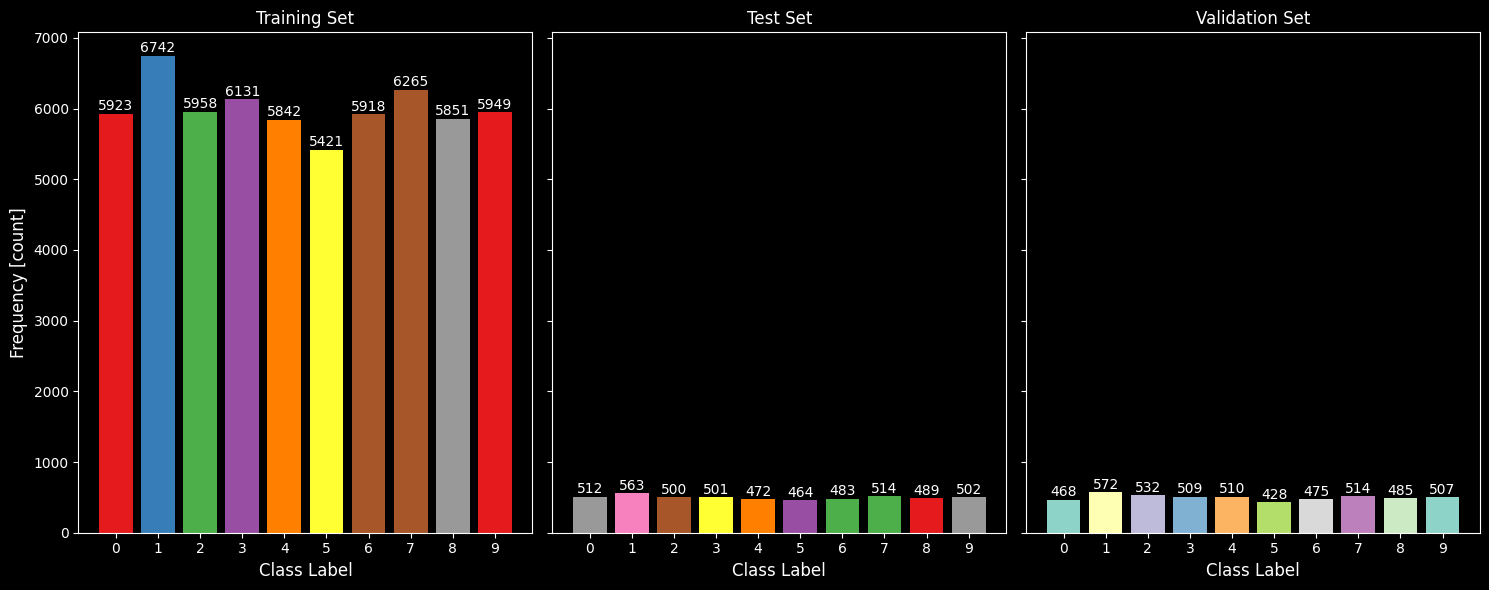

In [21]:
class_labels = train_dataset_norm.classes  # Class labels
plt.style.use('dark_background')
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Plot training set distribution
axes[0].bar(class_labels, train_class_distributions, color=[plt.cm.get_cmap("Set1", 10)(i) for i in range(9)])
axes[0].set_title("Training Set",fontsize=12)
axes[0].set_xlabel("Class Label",fontsize=12)
axes[0].set_ylabel("Frequency [count]",fontsize=12)

# Add counts above bars for the training set
for i, count in enumerate(train_class_distributions):
    axes[0].text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

# Plot test set distribution
axes[1].bar(class_labels, test_class_distributions, color=[plt.cm.get_cmap("Set1_r", 10)(i) for i in range(9)])
axes[1].set_title("Test Set",fontsize=12)
axes[1].set_xlabel("Class Label",fontsize=12)

# Add counts above bars for the test set
for i, count in enumerate(test_class_distributions):
    axes[1].text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Plot validation set distribution
axes[2].bar(class_labels, val_class_distributions, color=[plt.cm.get_cmap("Set3", 10)(i) for i in range(9)])
axes[2].set_title("Validation Set",fontsize=12)
axes[2].set_xlabel("Class Label",fontsize=12)

# Add counts above bars for the validation set
for i, count in enumerate(val_class_distributions):
    axes[2].text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [22]:
### Building a Shallow Neural Network
#We're now ready to create our first neural network model. The model will be a shallow fully connected network. 
#The input layer
#Two hidden layers
#The output layer
# Image size from our transformer
height = 28
width = 28
torch.manual_seed(42)
model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(height * width, 512),
        nn.ReLU(),
        nn.Dropout(p=.3),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.Linear(128, 10) 
    )
print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
summary(model, input_size=(64,1,height,width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Flatten: 1-1                           [64, 784]                 --
├─Linear: 1-2                            [64, 512]                 401,920
├─ReLU: 1-3                              [64, 512]                 --
├─Dropout: 1-4                           [64, 512]                 --
├─Linear: 1-5                            [64, 128]                 65,664
├─ReLU: 1-6                              [64, 128]                 --
├─Dropout: 1-7                           [64, 128]                 --
├─Linear: 1-8                            [64, 10]                  1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 30.01
Input size (MB): 0.20
Forward/backward pass size (MB): 0.33
Params size (MB): 1.88
Estimated Total Size (MB): 2.41

In [24]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
def train_epoch(model, optimizer, loss_fn, data_loader,device):
    # Initialize variables for loss and accuracy
    training_loss = 0.0
    correct = 0
    total = 0
    # Set the model in training mode
    model.train()
    # Iterate over all batches in the training set
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # add inputs and targets to same device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradients to prepare for the next backpropagation
        optimizer.zero_grad()
        # Perform the forward pass and obtain the output
        output = model(inputs)
        # Calculate the loss
        loss = loss_fn(output, targets)
        # Perform backpropagation
        loss.backward()
        # Update model weights using the optimizer
        optimizer.step()
        # Update the cumulative training loss
        training_loss += loss.data.item() * inputs.size(0)
    # Calculate the average training loss over the epoch
    avg_loss = training_loss / len(data_loader.dataset)
    return avg_loss

In [47]:
def predict(model, data_loader,device):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([],device=device)
    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()
    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            # add inputs to same device
            inputs = inputs.to(device)
            output = model(inputs)
            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

In [29]:
def score(model, data_loader, loss_fn,device):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0
    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    #model.eval()
    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            # add inputs and targets to same device
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            # Calculating the loss function for this batch
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)
            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()
    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [30]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20,device = "cuda",Training_Accuracy = True):
    results = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Validation Loss', 'Validation Accuracy'])
    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss and accuracy.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader,device)
        if Training_Accuracy:
            training_loss, training_accuracy = score(model, train_loader, loss_fn,device)
        else:
            training_accuracy = 0
        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn,device)
        # Print out the results
        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.4f}, "
            f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}"
        )
        # Store the results in the dictionary
        results = pd.concat([results, pd.DataFrame({
            'Epoch': [epoch],
            'Training Loss': [training_loss],
            'Training Accuracy': [training_accuracy],
            'Validation Loss': [validation_loss],
            'Validation Accuracy': [validation_accuracy]
        })], ignore_index=True)
    return results  # Return the dictionary containing all results

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=10, bias=True)
)

In [32]:
results = train(model, optimizer, loss_fn, train_loader_norm, val_loader_norm, epochs=5,device=device)

Epoch: 1, Training Loss: 0.1366, Training Accuracy: 0.9576, Validation Loss: 0.1516, Validation Accuracy: 0.9548


Epoch: 2, Training Loss: 0.0935, Training Accuracy: 0.9707, Validation Loss: 0.1124, Validation Accuracy: 0.9656


Epoch: 3, Training Loss: 0.0804, Training Accuracy: 0.9747, Validation Loss: 0.1121, Validation Accuracy: 0.9636


Epoch: 4, Training Loss: 0.0745, Training Accuracy: 0.9763, Validation Loss: 0.1081, Validation Accuracy: 0.9672


Epoch: 5, Training Loss: 0.0584, Training Accuracy: 0.9818, Validation Loss: 0.1010, Validation Accuracy: 0.9688


In [33]:
# After the training loop, plot the results
def plot_results(results):
    # Set a dark background style
    plt.style.use('dark_background')
    # Create subplots for training and validation losses and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    # Plot training and validation losses
    ax[0].plot(results['Epoch'], results['Training Loss'], label='Training Loss')
    ax[0].plot(results['Epoch'], results['Validation Loss'], label='Validation Loss')
    ax[0].set_title('Losses Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    # Plot validation accuracy
    ax[1].plot(results['Epoch'], results['Training Accuracy'], label='Training Accuracy')
    ax[1].plot(results['Epoch'], results['Validation Accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    # Show the plots
    plt.tight_layout()
    plt.show()

In [34]:
results

,Epoch,Training Loss,Validation Loss,Validation Accuracy,Training Accuracy
0,1,0.136580,0.151642,0.9548,0.957617
1,2,0.093482,0.112423,0.9656,0.970683
2,3,0.080440,0.112149,0.9636,0.974650
3,4,0.074471,0.108067,0.9672,0.976267
4,5,0.058374,0.100966,0.9688,0.981833


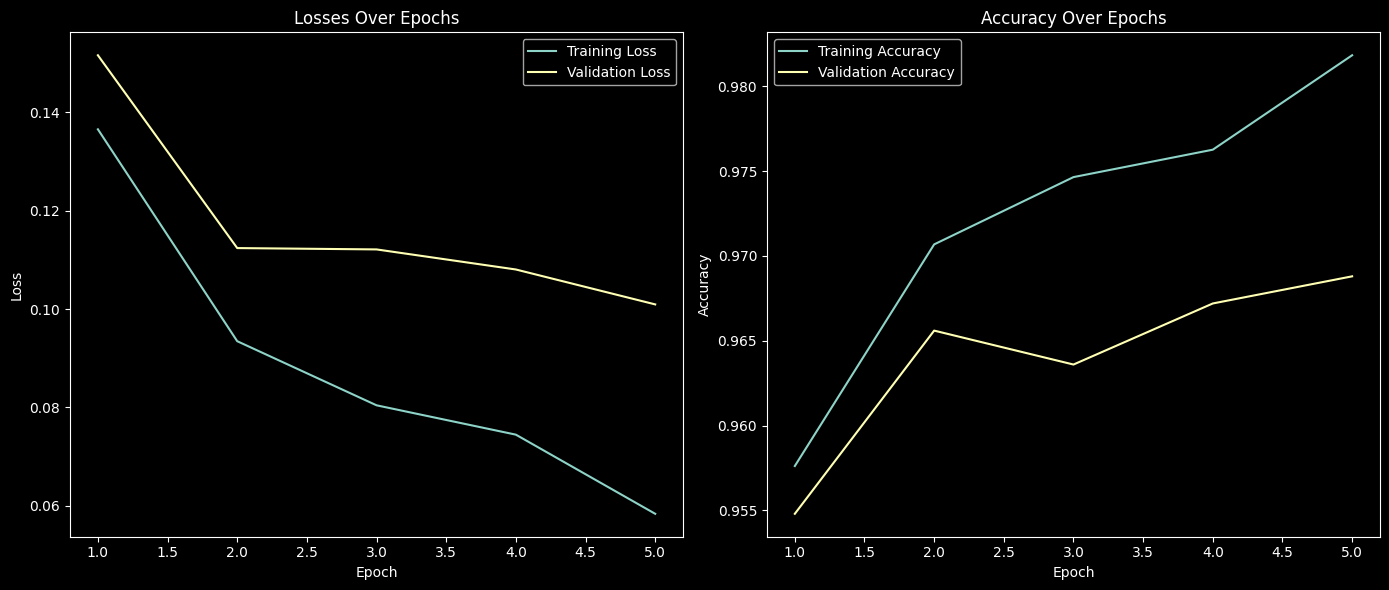

In [35]:
plot_results(results)

In [36]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0981, Testing Accuracy: 0.9742


In [48]:
### Make a prediction for each image in the validation set.
probabilities_test = predict(model, test_loader_norm,device)
predictions_test = torch.argmax(probabilities_test, dim=1)
print(predictions_test[:10])

tensor([7, 8, 9, 2, 8, 2, 2, 7, 1, 1])


In [49]:
true_labels = torch.cat([labels for _, labels in test_loader_norm], dim=0)
true_labels[:10]

tensor([7, 8, 3, 2, 8, 2, 2, 7, 1, 1])

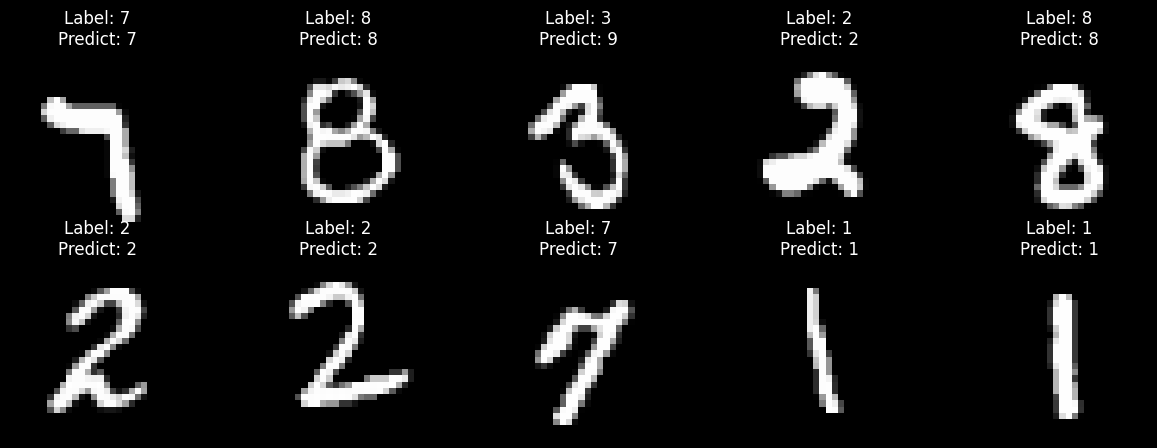

In [50]:
show_batch(test_loader_norm,predict_labels=predictions_test[:64])

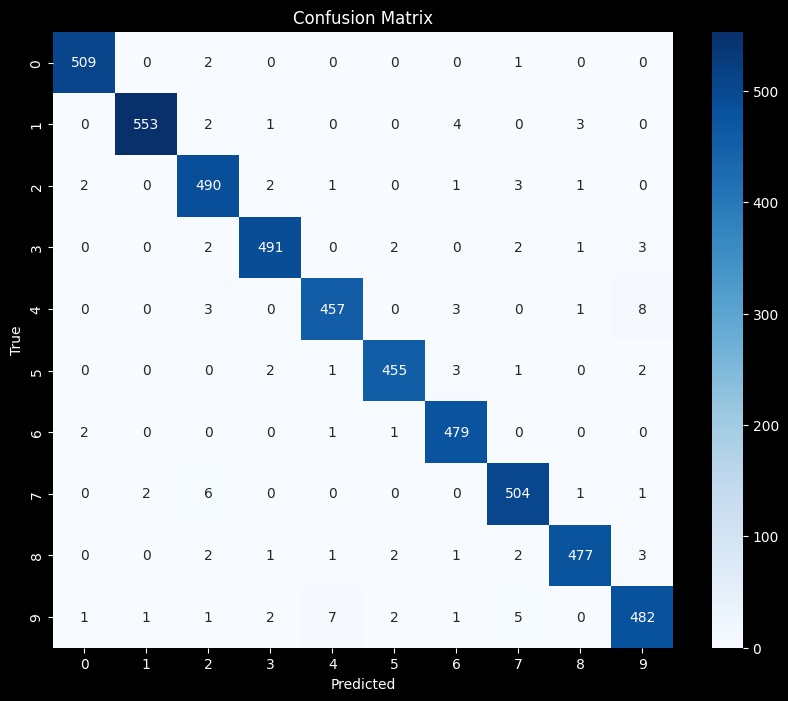

array([[509,   0,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0, 553,   2,   1,   0,   0,   4,   0,   3,   0],
       [  2,   0, 490,   2,   1,   0,   1,   3,   1,   0],
       [  0,   0,   2, 491,   0,   2,   0,   2,   1,   3],
       [  0,   0,   3,   0, 457,   0,   3,   0,   1,   8],
       [  0,   0,   0,   2,   1, 455,   3,   1,   0,   2],
       [  2,   0,   0,   0,   1,   1, 479,   0,   0,   0],
       [  0,   2,   6,   0,   0,   0,   0, 504,   1,   1],
       [  0,   0,   2,   1,   1,   2,   1,   2, 477,   3],
       [  1,   1,   1,   2,   7,   2,   1,   5,   0, 482]], dtype=int64)

In [51]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.numpy(), predictions_test.cpu().numpy())
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset_norm.classes, yticklabels=train_dataset_norm.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
conf_matrix

In [52]:
# Generate the classification report
report = classification_report(true_labels.numpy(), predictions_test.cpu().numpy(), target_names=train_dataset_norm.classes)
# Print the classification report
print("Classification Report :\n",report)

Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       512
           1       0.99      0.98      0.99       563
           2       0.96      0.98      0.97       500
           3       0.98      0.98      0.98       501
           4       0.98      0.97      0.97       472
           5       0.98      0.98      0.98       464
           6       0.97      0.99      0.98       483
           7       0.97      0.98      0.98       514
           8       0.99      0.98      0.98       489
           9       0.97      0.96      0.96       502

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [53]:
### save and load model 
torch.save(model,'mnist_model_nn.pth')
model = torch.load('mnist_model_nn.pth',weights_only=False)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=10, bias=True)
)

In [54]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0730, Testing Accuracy: 0.9794


In [55]:
### CNN Model
cnn_model = nn.Sequential(
        # First convolutional layer, followed by ReLU and MaxPool2d
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input channels = 3 (RGB), Output channels = 32
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # Pooling layer to reduce spatial dimensions
        # Second convolutional layer, followed by ReLU and MaxPool2d
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Input channels = 32, Output channels = 64
        nn.ReLU(),
        nn.MaxPool2d(2, 2),  # Pooling layer to further reduce spatial dimensions
        nn.Dropout(.3),
        # Flatten layer to convert 2D image data to 1D vector
        nn.Flatten(),
        # Fully connected layer (FC1) with 512 neurons
        nn.Linear(64 * 7 * 7, 512),  # Input size depends on the output shape from the conv layers
        nn.ReLU(),
        nn.Dropout(.2),
        # Output layer with 10 neurons (for 10 classes)
        nn.Linear(512, 10)
    )
print("model type:", type(cnn_model))
print("model structure:")
print(cnn_model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.3, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=3136, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=512, out_features=10, bias=True)
)


In [56]:
summary(cnn_model, input_size=(64, 1, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 32, 14, 14]          --
├─Conv2d: 1-4                            [64, 64, 14, 14]          18,496
├─ReLU: 1-5                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 64, 7, 7]            --
├─Dropout: 1-7                           [64, 64, 7, 7]            --
├─Flatten: 1-8                           [64, 3136]                --
├─Linear: 1-9                            [64, 512]                 1,606,144
├─ReLU: 1-10                             [64, 512]                 --
├─Dropout: 1-11                          [64, 512]                 --
├─Linear: 1-12                           [64, 10]                  5,130


In [57]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # For classification tasks
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [58]:
cnn_model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.3, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=3136, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=512, out_features=10, bias=True)
)

In [59]:
results = train(cnn_model, optimizer, loss_fn, train_loader_norm, val_loader_norm, epochs=5,device=device)

Epoch: 1, Training Loss: 0.0551, Training Accuracy: 0.9824, Validation Loss: 0.0531, Validation Accuracy: 0.9834


Epoch: 2, Training Loss: 0.0336, Training Accuracy: 0.9894, Validation Loss: 0.0455, Validation Accuracy: 0.9854


Epoch: 3, Training Loss: 0.0229, Training Accuracy: 0.9931, Validation Loss: 0.0326, Validation Accuracy: 0.9904


Epoch: 4, Training Loss: 0.0223, Training Accuracy: 0.9925, Validation Loss: 0.0333, Validation Accuracy: 0.9880


Epoch: 5, Training Loss: 0.0177, Training Accuracy: 0.9943, Validation Loss: 0.0304, Validation Accuracy: 0.9914


In [60]:
results

,Epoch,Training Loss,Validation Loss,Validation Accuracy,Training Accuracy
0,1,0.055106,0.053069,0.9834,0.982400
1,2,0.033590,0.045496,0.9854,0.989367
2,3,0.022886,0.032610,0.9904,0.993133
3,4,0.022321,0.033348,0.9880,0.992533
4,5,0.017667,0.030418,0.9914,0.994317


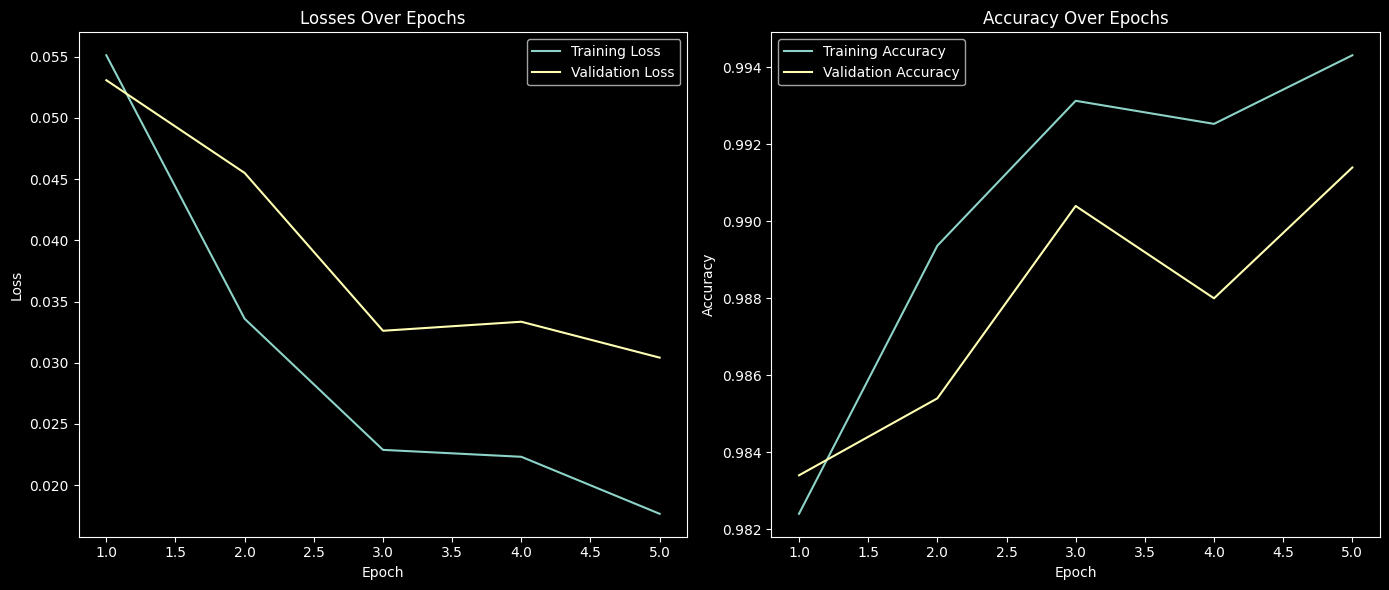

In [61]:
plot_results(results)

In [62]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(cnn_model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0392, Testing Accuracy: 0.9880


In [63]:
### Make a prediction for each image in the validation set.
probabilities_test = predict(cnn_model, test_loader_norm,device)
predictions_test = torch.argmax(probabilities_test, dim=1)
print(predictions_test[:10])

tensor([7, 8, 3, 2, 8, 2, 2, 7, 1, 1])


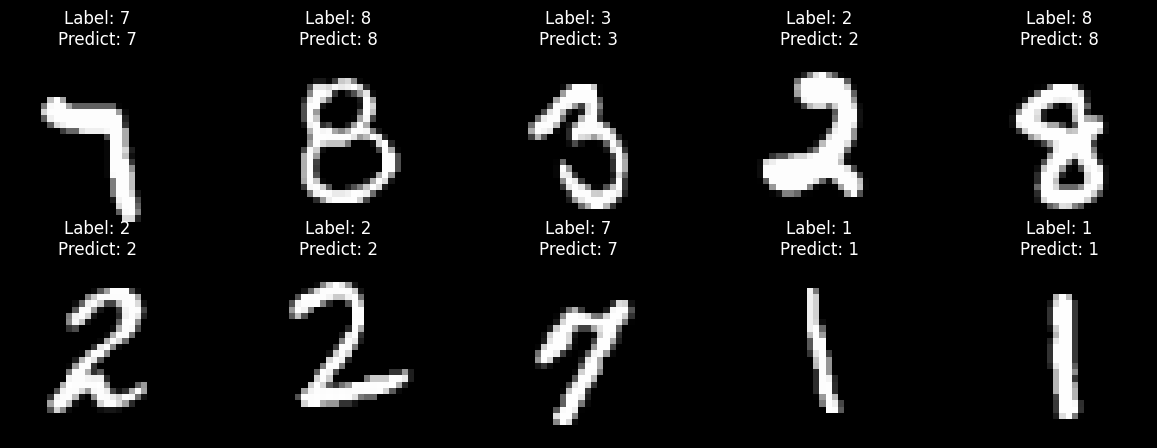

In [64]:
show_batch(test_loader_norm,predict_labels=predictions_test[:64])

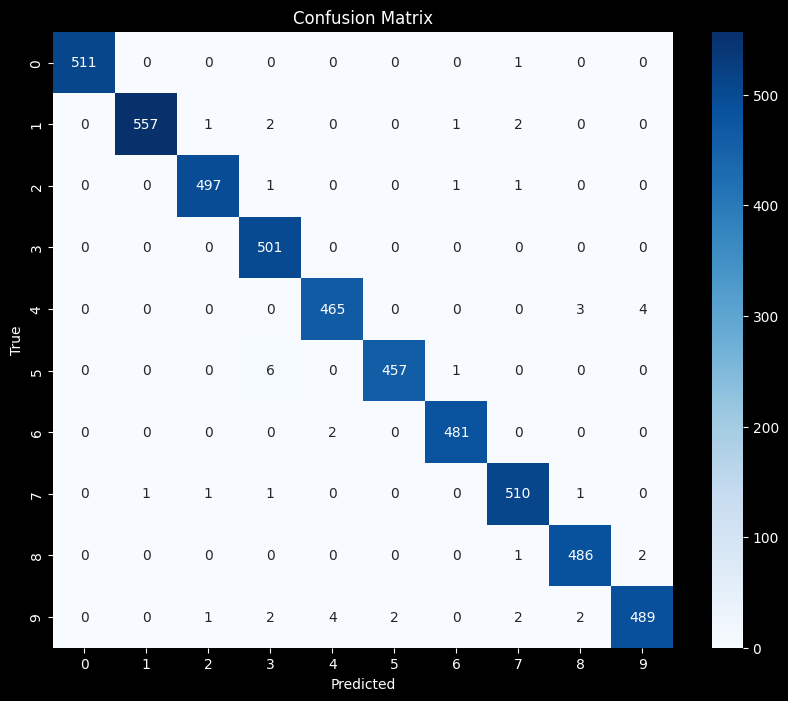

array([[511,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0, 557,   1,   2,   0,   0,   1,   2,   0,   0],
       [  0,   0, 497,   1,   0,   0,   1,   1,   0,   0],
       [  0,   0,   0, 501,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 465,   0,   0,   0,   3,   4],
       [  0,   0,   0,   6,   0, 457,   1,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0, 481,   0,   0,   0],
       [  0,   1,   1,   1,   0,   0,   0, 510,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1, 486,   2],
       [  0,   0,   1,   2,   4,   2,   0,   2,   2, 489]], dtype=int64)

In [65]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels.numpy(), predictions_test.cpu().numpy())
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset_norm.classes, yticklabels=train_dataset_norm.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
conf_matrix

In [66]:
# Generate the classification report
report = classification_report(true_labels.numpy(), predictions_test.cpu().numpy(), target_names=train_dataset_norm.classes)
# Print the classification report
print("Classification Report :\n",report)

Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      0.99      0.99       563
           2       0.99      0.99      0.99       500
           3       0.98      1.00      0.99       501
           4       0.99      0.99      0.99       472
           5       1.00      0.98      0.99       464
           6       0.99      1.00      0.99       483
           7       0.99      0.99      0.99       514
           8       0.99      0.99      0.99       489
           9       0.99      0.97      0.98       502

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [67]:
### save and load model 
torch.save(cnn_model,'mnist_model_cnn.pth')
cnn_model = torch.load('mnist_model_cnn.pth',weights_only=False)
cnn_model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.3, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=3136, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=512, out_features=10, bias=True)
)

In [68]:
### Make a Score for each image in the validation set.
test_loss, test_accuracy = score(cnn_model, test_loader_norm, loss_fn,device)
# Print out the results
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.0283, Testing Accuracy: 0.9908
